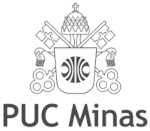

## Programa de Pós Graduação em Informática

### Disciplina: Indução de Regras e Árvores de Decisão

### Aluno: Felipe A. L. Reis

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from irad_helper import load_data, split_data
from irad_training import cross_validation, performance_measure, print_statistics
from irad_outliers import rm_outliers_1_percent, rm_outliers_mad, rm_outliers_irq, rm_outliers_2sd
from irad_plot import draw_tree, seaborn_plot, seaborn_bar, seaborn_bar_hue, bar_plot_with_labels, plot_theme

In [2]:
import datetime
import os, shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

#impressão de árvore de decisão
from sklearn.tree import export_graphviz
from io import StringIO
import pydotplus

---
# Aprendizado de Dados de Saúde Pública da Coréia do Sul

O trabalho a seguir foi desenvolvido para tarefas de aprendizado de máquinas em uma base de dados de saúde pública da Coréia.

A base é denominada **[National Health Insurance Corporation_Health Checkup Information](https://www.data.go.kr/data/15007122/fileData.do#/layer_data_infomation)** (tradução automática de coreano para inglês) e está disponível no [portal público de dados do governo da Coréia](https://www.data.go.kr/data/15007122/fileData.do#/layer_data_infomation).

A base de dados foi obtida à partir da base **[Body signal of smoking](https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking)**, disponível no [Kaggle](https://www.kaggle.com/). Essa última base corresponde a uma versão simplificada da base original.

A base [National Health Insurance Corporation_Health Checkup Information](https://www.data.go.kr/data/15007122/fileData.do#/layer_data_infomation) contém 1.000.000 de registros de check-up de saúde e seus dependentes com mais de 40 anos, membros locais que são chefes de família e membros locais com mais de 40 anos e aqueles que atingiram a idade de 40 e 66 entre os sujeitos a check-up geral de saúde.

São dados abertos que consistem em informações básicas (sexo, idade, código do teste, etc.) e detalhes do exame (altura, peso, colesterol total, hemoglobina, etc.).

As informações de uso de cigarros não englobam cigarros eletrônicos.

---
---
# Parametrização do Sistema

Defina abaixo as opções para parametrização do sistema.

In [3]:
class Params:
    frac_data = 1.0        #percentual dos dados a serem utilizados no treinamento
    only_male = True       #utiliza somente dados de homens (ignora mulheres, devido ao baixo consumo de tabaco)
    use_ex_smokers = True  #remove ex-fumantes do conjunto de dados (facilita diferenciação fumantes)
    outlier_method = '2sd' #técnica de remoção de outliers ('2sd', 'mad', 'irq', '1pe')
    
    def get_class_names(self):
        if(self.use_ex_smokers):
            return ['Não Fumante', 'Ex-Fumante', 'Fumante']
        return ['Não Fumante', 'Fumante']
    
    def get_ignore_columns_outlier(self):
        return ['smoking_status']
        #return ['smoking']
    
    def get_column_training(self):
        return ['gender_num', 'age', 'drinking',
                'imc','waist', 'glucose',
                'systolic_blood_pressure',
                'diastolic_blood_pressure',
                'total_cholesterol','triglycerides',
                'hdl_cholesterol','ldl_cholesterol',
                'hemoglobin','serum_creatinine',
                'ast_sgot','alt_sgpt','gama_gtp',
                'hearing_left', 'hearing_right', 
                'sight_left', 'sight_right',
                'urine_protein'
               ]
    
    def get_column_names(self):
        columns = self.get_column_training()
        columns.append('smoking_status')
        #columns.append('smoking')
        return columns

---
---
# Pré Processamento

Esta seção será utilizada para pré processamento da base de dados, realizando as seguinte etapas:

1. Remoção de *outliers* (atualização de dados)
2. Processamento de dados ausentes 
3. Redução de dimensionalidade 
4. Transformação de atributos
5. Balanceamento dos dados (+ *Cross-validation*)

In [4]:
data = load_data('dataset/smoking-dataset-initial.csv')
data

,Unnamed: 0,ID,gender,height,weight,waist,sight_left,sight_right,hearing_left,hearing_right,...,smoking_status,drinking,gender_num,age,drink,smoking,dentist,caries,imc,imc_grau
0,0,1,M,165,60,72.1,1.2,1.5,1.0,1.0,...,1.0,0.0,1,40,N,NF,N,NaN,22.038567,N
1,1,2,F,150,65,81.0,0.8,0.8,1.0,1.0,...,1.0,0.0,2,60,N,NF,N,NaN,28.888889,SP
2,2,3,F,155,55,70.0,0.6,0.7,1.0,1.0,...,1.0,0.0,2,55,N,NF,N,NaN,22.892820,N
3,3,4,M,160,70,90.8,1.0,1.0,1.0,2.0,...,1.0,0.0,1,60,N,NF,S,N,27.343750,SP
4,4,5,F,155,50,75.2,1.5,1.2,1.0,1.0,...,1.0,0.0,2,55,N,NF,N,NaN,20.811655,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999652,999995,999996,F,145,55,81.0,0.9,1.0,1.0,1.0,...,1.0,0.0,2,60,N,NF,N,NaN,26.159334,SP
999653,999996,999997,F,160,55,76.5,1.5,1.5,1.0,1.0,...,1.0,1.0,2,55,S,NF,N,NaN,21.484375,N
999654,999997,999998,M,175,70,85.0,1.2,1.2,1.0,1.0,...,1.0,1.0,1,40,S,NF,N,NaN,22.857143,N
999655,999998,999999,F,160,70,91.0,0.6,0.5,1.0,1.0,...,1.0,0.0,2,40,N,NF,N,NaN,27.343750,SP


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999657 entries, 0 to 999656
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                999657 non-null  int64  
 1   ID                        999657 non-null  int64  
 2   gender                    999657 non-null  object 
 3   height                    999657 non-null  int64  
 4   weight                    999657 non-null  int64  
 5   waist                     999551 non-null  float64
 6   sight_left                999401 non-null  float64
 7   sight_right               999406 non-null  float64
 8   hearing_left              999436 non-null  float64
 9   hearing_right             999428 non-null  float64
 10  systolic_blood_pressure   992125 non-null  float64
 11  diastolic_blood_pressure  992123 non-null  float64
 12  glucose                   992055 non-null  float64
 13  total_cholesterol         402143 non-null  f

### Gerencia parametrização do sistema

In [6]:
params = Params()

if(params.frac_data < 1.):
    data = data.sample(frac=params.frac_data)

if(params.only_male):
    data = data[(data.gender == 'M')]
    
if(not params.use_ex_smokers):
    data = data[(data.smoking != 'EX')]
    
if(params.outlier_method == '2sd'):
    rm_outlier = rm_outliers_2sd
elif(params.outlier_method == 'mad'):
    rm_outlier = rm_outliers_mad
elif(params.outlier_method == 'irq'):
    rm_outlier = rm_outliers_irq
elif(params.outlier_method == '1pe'):
    rm_outlier = rm_outliers_1_percent

print('------ Resumo Parâmetros ------\n')
print('- Fração Dados:    ', params.frac_data)
print('- Somente Homens:  ', params.only_male)
print('- Ex-fumantes:     ', params.use_ex_smokers)
print('- Outlier Method:  ', params.outlier_method.upper())
print()
print('- Num registros:', len(data))

------ Resumo Parâmetros ------

- Fração Dados:     1.0
- Somente Homens:   True
- Ex-fumantes:      True
- Outlier Method:   2SD

- Num registros: 510526


### 1. Remoção Outliers

In [7]:
#ver método definido na parametrização do sistema
data = rm_outlier(data[params.get_column_names()], params.get_ignore_columns_outlier())
print(len(data))

#qtd tuplas: (2sd: 280.736), (mad: 27.201), (irq: 112.519), (1pc: 308.880)

122240


### 2. Processamento de dados ausentes 

In [8]:
data = data[params.get_column_names()]
data

,gender_num,age,drinking,imc,waist,glucose,systolic_blood_pressure,diastolic_blood_pressure,total_cholesterol,triglycerides,...,serum_creatinine,ast_sgot,alt_sgpt,gama_gtp,hearing_left,hearing_right,sight_left,sight_right,urine_protein,smoking_status
0,1,40,0.0,22.038567,72.1,90.0,127.0,79.0,188.0,58.0,...,1.1,21.0,27.0,21.0,1.0,1.0,1.2,1.5,1.0,1.0
5,1,40,1.0,24.835646,94.0,86.0,114.0,72.0,234.0,183.0,...,1.1,25.0,32.0,26.0,1.0,1.0,1.2,1.2,1.0,3.0
16,1,50,1.0,25.390625,90.0,94.0,138.0,88.0,223.0,328.0,...,1.0,29.0,54.0,24.0,1.0,1.0,0.6,0.6,1.0,1.0
25,1,40,0.0,20.202020,77.5,87.0,130.0,70.0,174.0,122.0,...,0.9,18.0,10.0,15.0,1.0,1.0,1.5,1.5,1.0,1.0
27,1,80,1.0,24.973985,82.0,104.0,139.0,85.0,195.0,75.0,...,1.4,33.0,22.0,29.0,1.0,1.0,0.5,0.7,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999624,1,60,1.0,24.221453,87.0,96.0,110.0,70.0,198.0,117.0,...,1.1,23.0,19.0,43.0,1.0,1.0,0.4,0.4,1.0,3.0
999625,1,50,1.0,22.491349,73.0,103.0,116.0,72.0,276.0,75.0,...,0.9,40.0,44.0,25.0,1.0,1.0,1.2,1.2,1.0,1.0
999633,1,55,1.0,21.224490,78.2,110.0,120.0,70.0,224.0,73.0,...,0.9,24.0,14.0,35.0,1.0,1.0,0.6,2.0,1.0,2.0
999649,1,60,1.0,29.387755,99.5,98.0,120.0,74.0,142.0,121.0,...,0.8,66.0,58.0,36.0,1.0,1.0,0.9,0.9,1.0,2.0


#### Iterative Imputer

Imputação de dados ausentes utilizando técnica multivariada.
Nela, os dados imputados são dependentes das demais features.

In [9]:
idata = data

'''
#provavelmente o KNN Imputer terá um melhor resultado, porém é muito lenta sua execução.
min_date = datetime.datetime.now()

#imputer = SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None)
#imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputer = IterativeImputer(random_state=0)
idata = pd.DataFrame(imputer.fit_transform(data))
idata.columns = data.columns
idata.index = data.index
#idata

max_date = datetime.datetime.now()
print(max_date-min_date)
'''

'\n#provavelmente o KNN Imputer terá um melhor resultado, porém é muito lenta sua execução.\nmin_date = datetime.datetime.now()\n\n#imputer = SimpleImputer(missing_values=np.nan, strategy=\'mean\', fill_value=None)\n#imputer = KNNImputer(n_neighbors=5, weights="uniform")\nimputer = IterativeImputer(random_state=0)\nidata = pd.DataFrame(imputer.fit_transform(data))\nidata.columns = data.columns\nidata.index = data.index\n#idata\n\nmax_date = datetime.datetime.now()\nprint(max_date-min_date)\n'

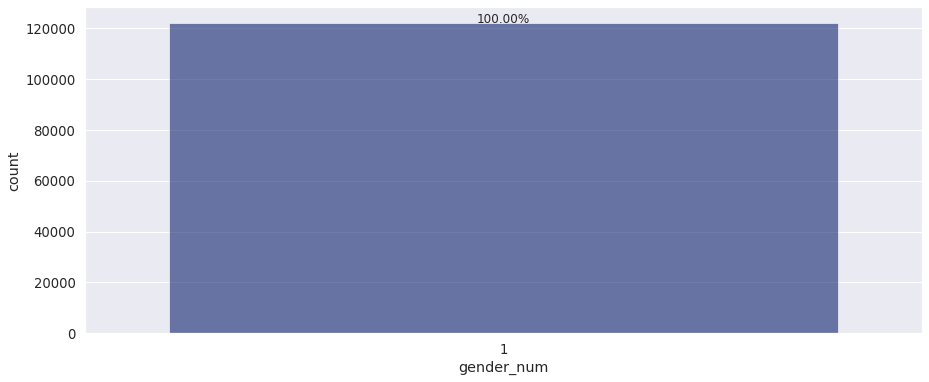

In [10]:
seaborn_bar(idata, x="gender_num", title="")

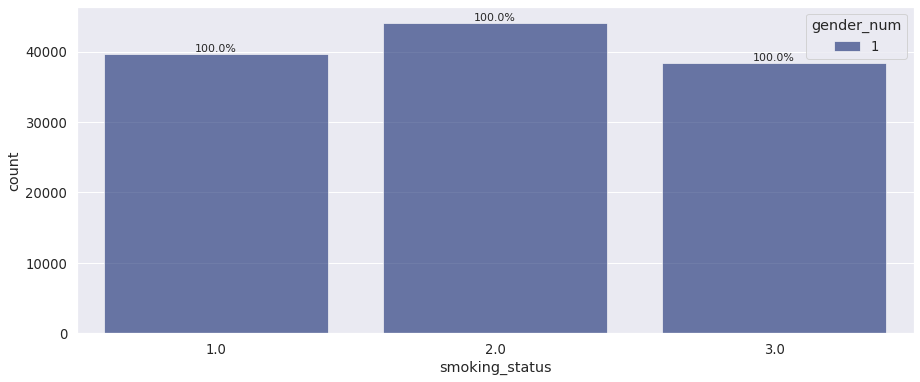

In [11]:
seaborn_bar_hue(idata, x="smoking_status", hue="gender_num", title="")

#### Altera tipo das colunas e atualiza, para imputação de valore inválidos.

In [12]:
'''
idata['gender_num'] = np.round(idata['gender_num']).astype('int')
idata['drinking'] = np.round(idata['drinking']).astype('int')
idata['age'] = idata['age'].transform(lambda a: 5. * round(a / 5.)).astype('int')

#altera tipo das colunas
idata['gender_num'] = idata['gender_num'] - 1

for col in ['age', 'smoking_status']:
    idata[col] = idata[col].astype('int')

for col in ['gender_num']:#, 'drinking']:
    idata[col] = idata[col].astype('boolean')
    
idata.info()
'''

"\nidata['gender_num'] = np.round(idata['gender_num']).astype('int')\nidata['drinking'] = np.round(idata['drinking']).astype('int')\nidata['age'] = idata['age'].transform(lambda a: 5. * round(a / 5.)).astype('int')\n\n#altera tipo das colunas\nidata['gender_num'] = idata['gender_num'] - 1\n\nfor col in ['age', 'smoking_status']:\n    idata[col] = idata[col].astype('int')\n\nfor col in ['gender_num']:#, 'drinking']:\n    idata[col] = idata[col].astype('boolean')\n    \nidata.info()\n"

### 3. Separação de Dados e Rótulos

In [13]:
idata[pd.isnull(idata['smoking_status'])]

,gender_num,age,drinking,imc,waist,glucose,systolic_blood_pressure,diastolic_blood_pressure,total_cholesterol,triglycerides,...,serum_creatinine,ast_sgot,alt_sgpt,gama_gtp,hearing_left,hearing_right,sight_left,sight_right,urine_protein,smoking_status


In [14]:
#definição de rótulo de dados
data_y = idata[['smoking_status']].astype('int')
data_y

,smoking_status
0,1
5,3
16,1
25,1
27,1
...,...
999624,3
999625,1
999633,2
999649,2


In [15]:
len(idata[idata['smoking_status'] == 1.])

39720

In [16]:
data_x = idata.drop('smoking_status', axis=1)
data_x

,gender_num,age,drinking,imc,waist,glucose,systolic_blood_pressure,diastolic_blood_pressure,total_cholesterol,triglycerides,...,hemoglobin,serum_creatinine,ast_sgot,alt_sgpt,gama_gtp,hearing_left,hearing_right,sight_left,sight_right,urine_protein
0,1,40,0.0,22.038567,72.1,90.0,127.0,79.0,188.0,58.0,...,15.0,1.1,21.0,27.0,21.0,1.0,1.0,1.2,1.5,1.0
5,1,40,1.0,24.835646,94.0,86.0,114.0,72.0,234.0,183.0,...,16.4,1.1,25.0,32.0,26.0,1.0,1.0,1.2,1.2,1.0
16,1,50,1.0,25.390625,90.0,94.0,138.0,88.0,223.0,328.0,...,16.6,1.0,29.0,54.0,24.0,1.0,1.0,0.6,0.6,1.0
25,1,40,0.0,20.202020,77.5,87.0,130.0,70.0,174.0,122.0,...,16.0,0.9,18.0,10.0,15.0,1.0,1.0,1.5,1.5,1.0
27,1,80,1.0,24.973985,82.0,104.0,139.0,85.0,195.0,75.0,...,14.3,1.4,33.0,22.0,29.0,1.0,1.0,0.5,0.7,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999624,1,60,1.0,24.221453,87.0,96.0,110.0,70.0,198.0,117.0,...,15.1,1.1,23.0,19.0,43.0,1.0,1.0,0.4,0.4,1.0
999625,1,50,1.0,22.491349,73.0,103.0,116.0,72.0,276.0,75.0,...,13.4,0.9,40.0,44.0,25.0,1.0,1.0,1.2,1.2,1.0
999633,1,55,1.0,21.224490,78.2,110.0,120.0,70.0,224.0,73.0,...,15.1,0.9,24.0,14.0,35.0,1.0,1.0,0.6,2.0,1.0
999649,1,60,1.0,29.387755,99.5,98.0,120.0,74.0,142.0,121.0,...,15.1,0.8,66.0,58.0,36.0,1.0,1.0,0.9,0.9,1.0


#### Separação Conjuntos de Treino e Testes

In [17]:
x_train, x_test, y_train, y_test = split_data(data_x, data_y)
print('Treino:', x_train.shape, y_train.shape)
print('Teste: ', x_test.shape, y_test.shape)

data_x, data_y = x_train, y_train

Treino: (97792, 22) (97792, 1)
Teste:  (24448, 22) (24448, 1)


### 4. Redução de dimensionalidade e Normalização

In [18]:
#resultados mantiveram-se semelhantes após o uso da normalização
'''
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(data_x)) #scaling the data

scaled_data.columns = data_x.columns
scaled_data.index = data_x.index

data_x = scaled_data
data_x
'''

'\nscalar = StandardScaler()\nscaled_data = pd.DataFrame(scalar.fit_transform(data_x)) #scaling the data\n\nscaled_data.columns = data_x.columns\nscaled_data.index = data_x.index\n\ndata_x = scaled_data\ndata_x\n'

In [19]:
#resultados ficaram piores após uso do kernel PCA
'''
pca = PCA(n_components = 9)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
data_x = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])
data_x
'''

"\npca = PCA(n_components = 9)\npca.fit(scaled_data)\ndata_pca = pca.transform(scaled_data)\ndata_x = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9'])\ndata_x\n"

---
---
# Classificadores

Esta seção será utilizada para criação de classificadores, na tentativa de identificar possíveis fumantes.

In [20]:
'''
#cria classificador usando holdout
smoking_tree_hold = DecisionTreeClassifier()#(max_depth=4)
smoking_tree_hold.fit(data_x, data_y)

#gera predições
predictions = smoking_tree_hold.predict(x_test)
print_statistics(y_test, predictions)
'''

'\n#cria classificador usando holdout\nsmoking_tree_hold = DecisionTreeClassifier()#(max_depth=4)\nsmoking_tree_hold.fit(data_x, data_y)\n\n#gera predições\npredictions = smoking_tree_hold.predict(x_test)\nprint_statistics(y_test, predictions)\n'

### Classificador Árvore de Decisão

--- Validation ---

Fold 1:
Accuracy: 0.6323148220878171
F1-score: 0.6322492488882762

Fold 2:
Accuracy: 0.6374204697195821
F1-score: 0.6363429295510581

Fold 3:
Accuracy: 0.6346712748409394
F1-score: 0.6344374188812243

Fold 4:
Accuracy: 0.6256382059539706
F1-score: 0.6256199094665258

Fold 5:
Accuracy: 0.6381274055455188
F1-score: 0.6379900333457277


--- Test ---

Precisão:   0.6275217093934288
Revocação:  0.6274889269752164
F1 Score:   0.6274913761024437
Acurácia:   0.6275606384315697
Report:
              precision    recall  f1-score   support

 Não Fumante       0.63      0.64      0.63      8028
     Fumante       0.63      0.62      0.62      7886

    accuracy                           0.63     15914
   macro avg       0.63      0.63      0.63     15914
weighted avg       0.63      0.63      0.63     15914

TPR [0.63552566 0.61945219]
TNR [0.61945219 0.63552566]
FPR [0.38054781 0.36447434]
FNR [0.36447434 0.38054781]

Time spent: 0:04:11.298980


/home/falreis/anaconda3/envs/arvores/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


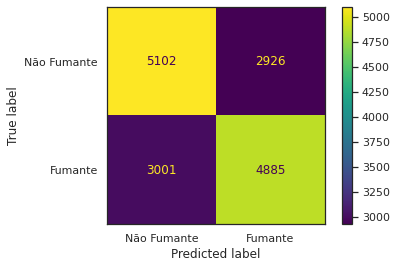

In [21]:
#executa a cross validação
plot_theme(style="white")
smoking_tree = cross_validation(DecisionTreeClassifier, data_x, data_y, x_test, y_test, 
                                params.get_class_names(), max_depth=4)

#desenha a árvore de decisão
draw_tree(smoking_tree, feature_names=x_train.columns,
          class_names=params.get_class_names(), filename='tree_cross.png')

#### [Link para imagem da árvore gerada](tree_cross.png)

### Classificador RandomForest

--- Validation ---

Fold 1:
Accuracy: 0.6594140287487236
F1-score: 0.6594045954550898

Fold 2:
Accuracy: 0.6603566098499725
F1-score: 0.6603519807158305

Fold 3:
Accuracy: 0.6612206425261173
F1-score: 0.6611513919412515

Fold 4:
Accuracy: 0.6558793496190402
F1-score: 0.6558563838305813

Fold 5:
Accuracy: 0.6640483858298641
F1-score: 0.6640456994948669


--- Test ---



/home/falreis/anaconda3/envs/arvores/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Precisão:   0.6571335644253447
Revocação:  0.6571382926685336
F1 Score:   0.6570940776565624
Acurácia:   0.6570943823048888
Report:
              precision    recall  f1-score   support

 Não Fumante       0.66      0.65      0.66      8028
     Fumante       0.65      0.66      0.66      7886

    accuracy                           0.66     15914
   macro avg       0.66      0.66      0.66     15914
weighted avg       0.66      0.66      0.66     15914

TPR [0.65221724 0.66205935]
TNR [0.66205935 0.65221724]
FPR [0.33794065 0.34778276]
FNR [0.34778276 0.33794065]

Time spent: 0:04:54.995335


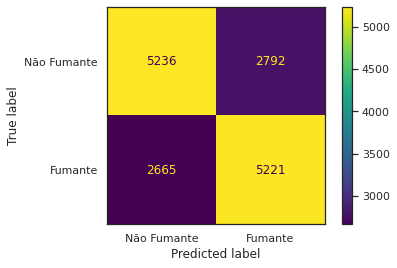

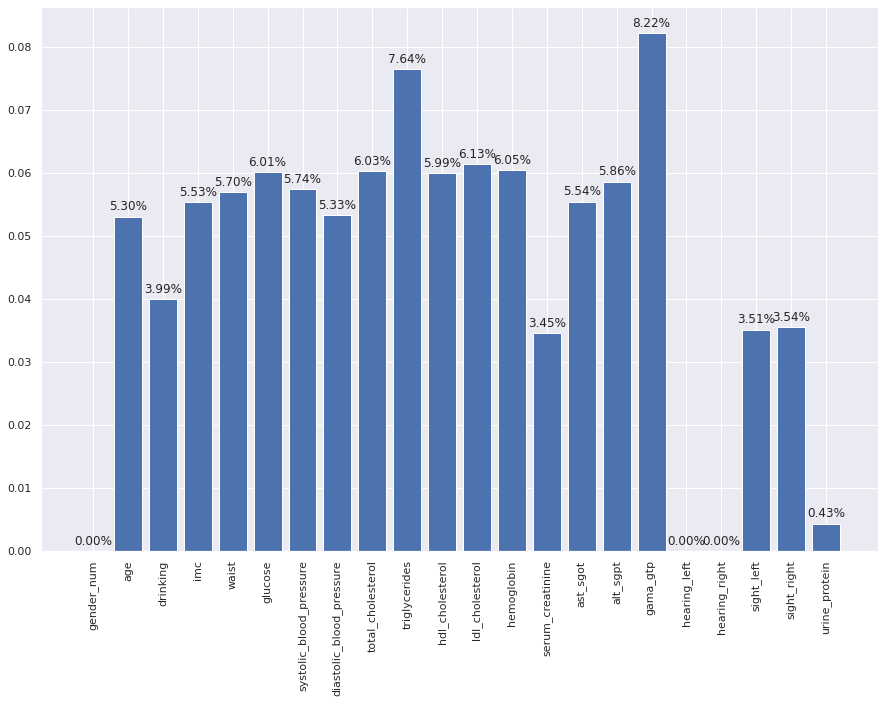

In [22]:
#executa a cross validação
plot_theme(style="white")
smoking_forest = cross_validation(RandomForestClassifier, data_x, data_y, x_test, y_test, 
                                params.get_class_names())

bar_plot_with_labels(params.get_column_training(), smoking_forest.feature_importances_)

### Classificador MLP

In [23]:
'''
#executa a cross validação
plot_theme(style="white")
smoking_forest = cross_validation(MLPClassifier, data_x, data_y, x_test, y_test, 
                                params.get_class_names())
'''

'\n#executa a cross validação\nplot_theme(style="white")\nsmoking_forest = cross_validation(MLPClassifier, data_x, data_y, x_test, y_test, \n                                params.get_class_names())\n'

#### Distribuição de Classes no Conjunto de Testes

A distribuição de Não Fumantes (1), Ex-Fumantes (2) e Fumantes (3), para o conjunto de testes, está disponível na figura abaixo.

Tal figura justifica o número de amostras classificadas como Não Fumantes (1).

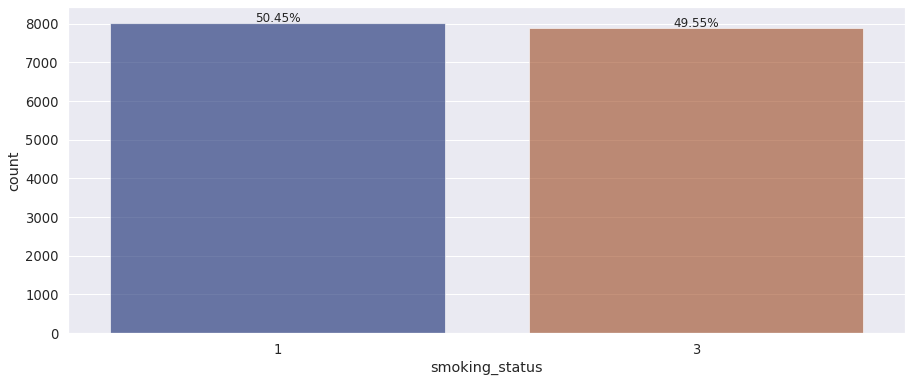

In [24]:
seaborn_bar(y_test, x="smoking_status", title="")